In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from scipy.stats import probplot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

# Part 1 : Original Time Series Analysis

In [2]:
#Load the data
data = pd.read_csv(r'D:\books for study\time series\project\infy_stock.csv')
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,INFY,EQ,1972.55,1968.95,1982.00,1956.9,1971.00,1974.40,1971.34,500691,9.870306e+13,14908,258080,0.5154
1,2015-01-02,INFY,EQ,1974.40,1972.00,2019.05,1972.0,2017.95,2013.20,2003.25,1694580,3.394669e+14,54166,1249104,0.7371
2,2015-01-05,INFY,EQ,2013.20,2009.90,2030.00,1977.5,1996.00,1995.90,2004.59,2484256,4.979911e+14,82694,1830962,0.7370
3,2015-01-06,INFY,EQ,1995.90,1980.00,1985.00,1934.1,1965.10,1954.20,1954.82,2416829,4.724458e+14,108209,1772070,0.7332
4,2015-01-07,INFY,EQ,1954.20,1965.00,1974.75,1950.0,1966.05,1963.55,1962.59,1812479,3.557162e+14,62463,1317720,0.7270


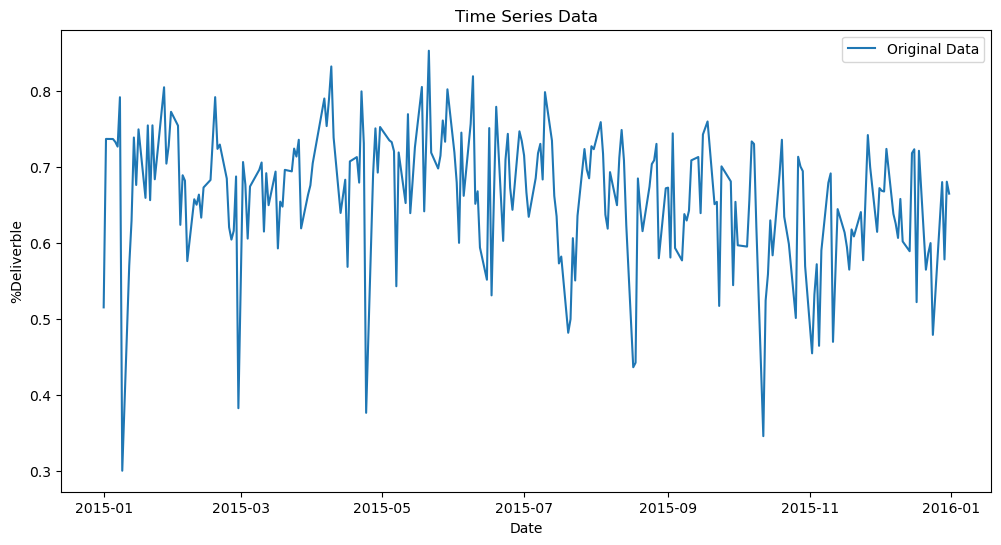

In [3]:
# Plot the data
data['Date'] = pd.to_datetime(data['Date'])
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['%Deliverble'], label='Original Data')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('%Deliverble')
plt.legend()
plt.show()

In [4]:
# Checking for null and duplicate values
print("Null values:\n", data.isnull().sum())
data = data.dropna()

print("\nDuplicate values:\n", data.duplicated().sum())
data = data.drop_duplicates()



Null values:
 Date                  0
Symbol                0
Series                0
Prev Close            0
Open                  0
High                  0
Low                   0
Last                  0
Close                 0
VWAP                  0
Volume                0
Turnover              0
Trades                0
Deliverable Volume    0
%Deliverble           0
dtype: int64

Duplicate values:
 0


In [5]:
#performing Time Series Decompostion
seasonality_period = 7 
decomposition = seasonal_decompose(data['%Deliverble'], period=seasonality_period)

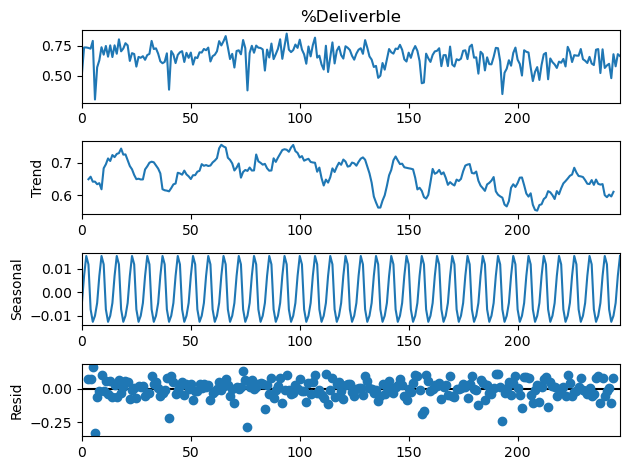

In [6]:
decomposition .plot()
plt.show()

ADF Statistic: -6.916144464772943
p-value: 1.178121027460387e-09


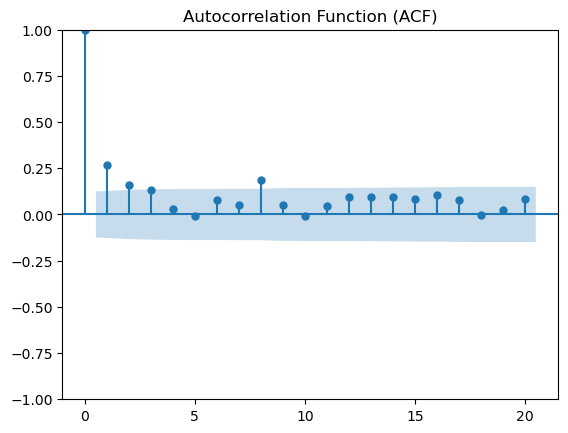

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


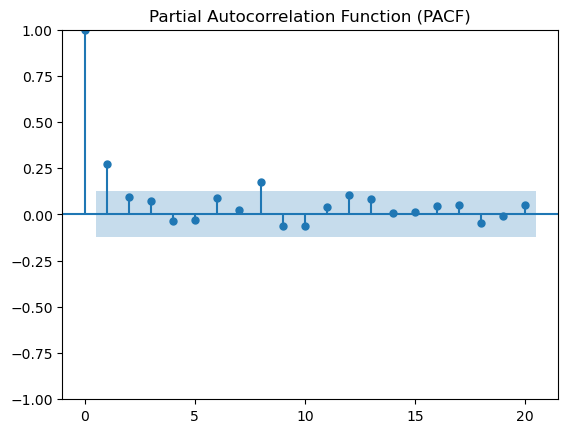

In [7]:
#Applying Augmented Dickey-Fuller Test & Plotting Autocorrelation & Partial Autocorrelation Functions
result = adfuller(data['%Deliverble'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


plot_acf(data['%Deliverble'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(data['%Deliverble'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()



In [8]:
# Compute AIC to identify the best order in the %Deliverable Column
order_aic = {}
for p in range(3): 
    for d in range(2):  
        for q in range(3): 
            try:
                model = ARIMA(data['%Deliverble'], order=(p, d, q))
                results = model.fit()
                order_aic[(p, d, q)] = results.aic
            except:
                continue

best_order = min(order_aic, key=order_aic.get)
print("Best AIC Order:", best_order)

# Fit the model with the best order
model = ARIMA(data['%Deliverble'], order=best_order)
results = model.fit()



C:\Users\hp\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best AIC Order: (2, 0, 1)


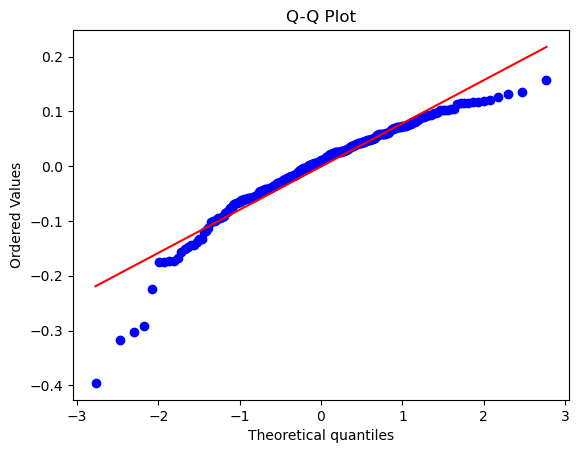

Ljung-Box test p-values: lb_pvalue


In [9]:
#Residual Analysis, Quantile-Quantile plot & Ljung Box Test to determine if the model is suitable for forcasting
residuals = results.resid

probplot(residuals, plot=plt)
plt.title('Q-Q Plot')
plt.show()

lb_stat, lbp_pvalue = acorr_ljungbox(residuals, lags=10)
print("Ljung-Box test p-values:", lbp_pvalue)


In [10]:
#Forcasting test values and calculating Mean Squared Error
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]
forecast = results.forecast(steps=len(test))

# forecasted values
print("Forecasted Values:")
print(forecast[:10])


# (MSE)
mse1 = mean_squared_error(test['%Deliverble'], forecast)
print("Mean Squared Error (MSE):", mse1)

Forecasted Values:
248    0.642752
249    0.638635
250    0.638079
251    0.638215
252    0.638483
253    0.638773
254    0.639065
255    0.639353
256    0.639637
257    0.639916
Name: predicted_mean, dtype: float64
Mean Squared Error (MSE): 0.005837183715132646


C:\Users\hp\AppData\Local\Temp\ipykernel_9944\4145352787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])


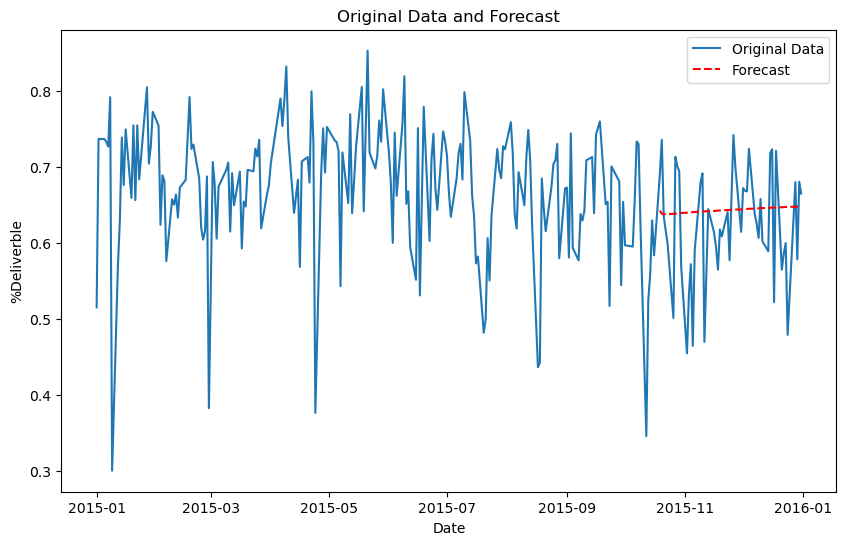

In [11]:
data['Date'] = pd.to_datetime(data['Date'])
test['Date'] = pd.to_datetime(test['Date'])

plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['%Deliverble'], label='Original Data')
plt.plot(test['Date'], forecast, label='Forecast', linestyle='--', color='red')
plt.title('Original Data and Forecast')
plt.xlabel('Date')
plt.ylabel('%Deliverble')
plt.legend()
plt.show()


# Part 2 : Deep Learning Time Series (Using GRU)

In [12]:
#Load the data
data = pd.read_csv(r'D:\books for study\time series\project\infy_stock.csv')
df = data['%Deliverble'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [13]:
#Test - Train Split
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

In [14]:
def create_sequences(df, seq_length):
    sequences = []
    for i in range(len(df) - seq_length):
        seq = df[i:i+seq_length]
        target = df[i+seq_length]
        sequences.append((seq, target))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

In [15]:
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [16]:
#Building GRU Model
model = Sequential()
model.add(GRU(units=50, activation='tanh', input_shape=(seq_length, 1)))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
#Training
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10

6/6 [==============================] - 2s 8ms/step - loss: 0.4651
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 0.2121
Epoch 3/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0629
Epoch 4/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0290
Epoch 5/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0405
Epoch 6/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0266
Epoch 7/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0211
Epoch 8/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0232
Epoch 9/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0227
Epoch 10/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0215


In [18]:
#Forcasting
predictions = model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [19]:
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

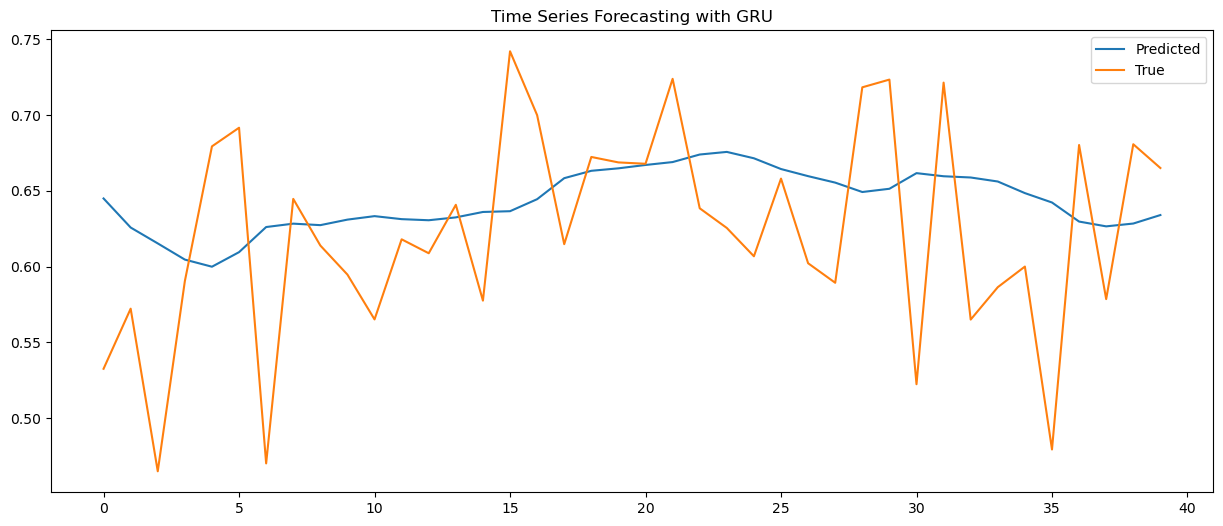

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(predictions_inv, label='Predicted')
plt.plot(y_test_inv, label='True')
plt.legend()
plt.title('Time Series Forecasting with GRU')
plt.show()

In [21]:
mse = mean_squared_error(y_test_inv, predictions_inv)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.005145150708888551


Mean Squared Error (MSE1): 0.005837183715132646
Mean Squared Error (MSE): 0.005145150708888551


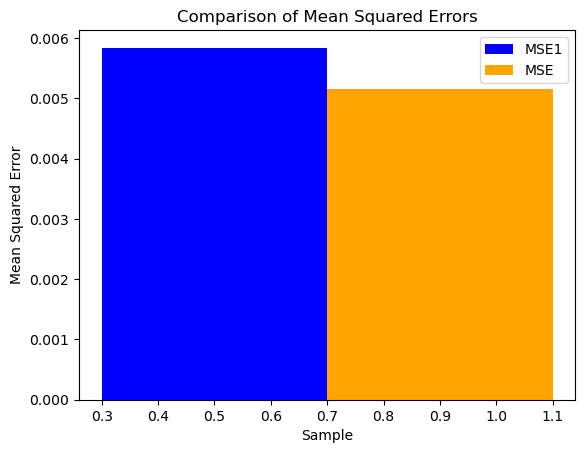

In [22]:
# (MSE)
mse1 = mean_squared_error(test['%Deliverble'], forecast)
print("Mean Squared Error (MSE1):", mse1)
mse = mean_squared_error(y_test_inv, predictions_inv)
print(f'Mean Squared Error (MSE): {mse}')
plt.bar(0.7 - 0.2, mse1, color='blue', width=0.4, label='MSE1')
plt.bar(0.7 + 0.2, mse, color='orange', width=0.4, label='MSE')


plt.xlabel('Sample')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Mean Squared Errors')
plt.legend()

# Part 3 :Clustering Techniques for Time Series Data

In [23]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data_column = data['%Deliverble']

data_array = data_column.values.reshape(-1, 1)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_array)


# 1 KMEANS

C:\Users\hp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


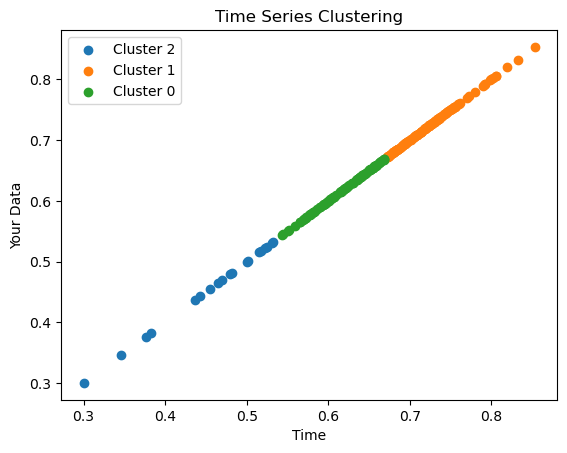

In [24]:
#Using K-Mean Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
data['Cluster'] = clusters

for cluster_id in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster_id]
    plt.scatter(cluster_data['%Deliverble'], cluster_data['%Deliverble'], label=f'Cluster {cluster_id}', marker='o')

plt.title('Time Series Clustering')
plt.xlabel('Time')
plt.ylabel('Your Data')
plt.legend()
plt.show()


# 2 DBSCAN

In [25]:
#DBSCAN Clustering
data_column = data['%Deliverble']

data_array = data_column.values.reshape(-1, 1)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_array)

dbscan = DBSCAN(eps=0.1, min_samples=5)
data['Cluster'] = dbscan.fit_predict(data_scaled)

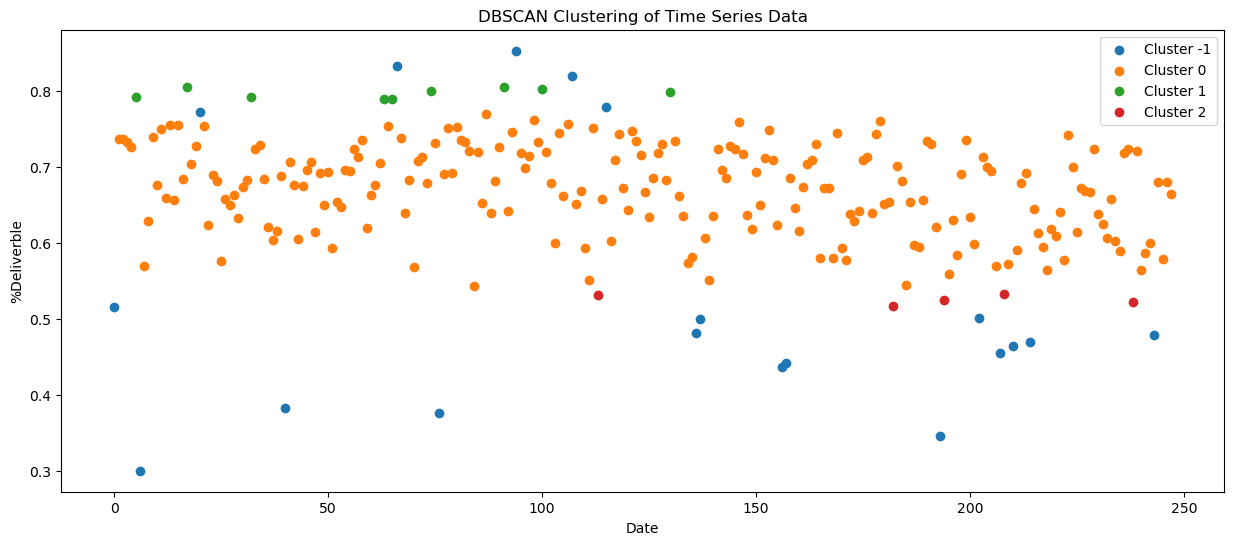

In [26]:
plt.figure(figsize=(15, 6))
for cluster_id in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster_id]
    plt.scatter(cluster_data.index, cluster_data['%Deliverble'], label=f'Cluster {cluster_id}', marker='o')

plt.title('DBSCAN Clustering of Time Series Data')
plt.xlabel('Date')
plt.ylabel('%Deliverble')
plt.legend()
plt.show()

# 3 OPTICS

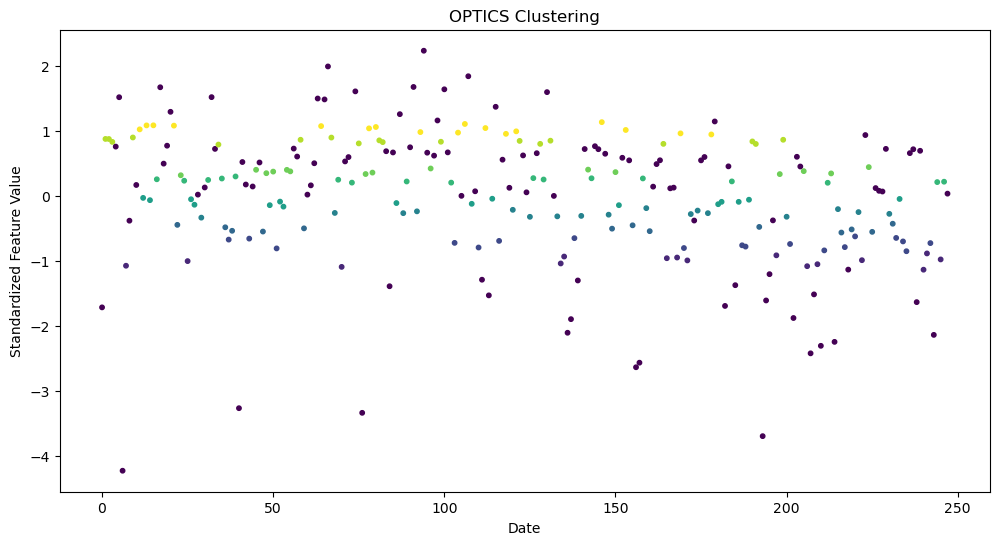

In [27]:
#OPTICS Clustering
feature_column = '%Deliverble'
X = data[[feature_column]].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
clusters = optics.fit_predict(X_scaled)

plt.figure(figsize=(12, 6))
plt.scatter(data.index, X_scaled, c=clusters, cmap='viridis', s=10)
plt.title('OPTICS Clustering')
plt.xlabel('Date')
plt.ylabel('Standardized Feature Value')
plt.show()